<a href="https://colab.research.google.com/github/fernando2393/DT2119-Final-Project/blob/Andres_V2/MusicGenreClassification_Andres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
from google.colab import files
files.upload()

Saving constants.py to constants.py
Saving features.py to features.py
Saving loader.py to loader.py


{'constants.py': b'# # Run locally\r\n# DATASETS = "Datasets/fma_small/"\r\n# METADATA = "Datasets/fma_metadata/"\r\n# MFCC = "Datasets/mfcc.csv"\r\n# SPECTROGRAM = "Datasets/spectrogram.csv"\r\n\r\n# Run on Google Colab\r\nDATASETS = "/content/drive/My Drive/Datasets/fma_small/"\r\nMETADATA = "/content/drive/My Drive/Datasets/fma_metadata/"\r\nMFCC = "/content/drive/My Drive/Datasets/mfcc.csv"\r\nSPECTROGRAM = "/content/drive/My Drive/Datasets/spectrogram.csv"\r\n',
 'features.py': b'import pandas as pd\r\nimport sklearn\r\nimport librosa.display\r\nimport librosa\r\nimport os\r\nfrom tqdm import tqdm\r\nimport warnings\r\nimport constants as cts\r\nimport numpy as np\r\n\r\n\r\ndef compute_feature(mode, filepath):\r\n    """\r\n    This method loads the a music track and computes the mfcc.\r\n    :param mode: allows to get either spectrogram or mfcc.\r\n    :param filepath: music track.\r\n    :return mfcc of the data track.\r\n    """\r\n    if mode == \'spectrogram\':\r\n        y,

In [3]:
import loader
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
def plot_history(history):

    fig, axs = plt.subplots(2)
    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    plt.show()

In [0]:
def build_model_Conv2D(input_shape):
    model = keras.Sequential()
    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    # output layer
    model.add(keras.layers.Dense(8, activation='softmax'))

    return model

In [0]:
def build_model_Conv1D(input_shape):
    model = keras.Sequential()
    # 1st conv layer
    model.add(keras.layers.Conv1D(32, 4, activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling1D(pool_size=4, strides=2, padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 2nd conv layer
    model.add(keras.layers.Conv1D(32, 2, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(keras.layers.BatchNormalization())
    # 3rd conv layer
    model.add(keras.layers.Conv1D(32, 2, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(keras.layers.BatchNormalization())
    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    # output layer
    model.add(keras.layers.Dense(8, activation='softmax'))

    return model

In [0]:
def predict(model, x, y):
    prediction = model.predict(x)
    predicted_index = np.argmax(prediction, axis=1)
    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [25]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = loader.get_train_val_test(mode='spectrogram')
print("There are the following classes:")
classes = set(y_train.tolist()) & set(y_val.tolist()) & set(y_test.tolist())
print(classes)

Calculating spectrogram...
There are the following classes:
{'Experimental', 'International', 'Instrumental', 'Rock', 'Folk', 'Pop', 'Electronic', 'Hip-Hop'}


In [26]:
# Remove small samples
x_train = np.delete(x_train, [3495, 3496, 3497])
y_train = np.delete(y_train, [3495, 3496, 3497])
x_train = np.rollaxis(np.dstack(x_train), -1)
x_val = np.rollaxis(np.dstack(x_val), -1)
x_test = np.rollaxis(np.dstack(x_test), -1)
# x_train = np.expand_dims(x_train, axis=3)
# x_val = np.expand_dims(x_val, axis=3)
# x_test = np.expand_dims(x_test, axis=3)

print(x_train.shape)
print(x_train.shape[1:])

(6394, 32, 474)
(32, 474)


In [0]:
# One-hot encoding of classes
dict_labels = {'Electronic': 0, 'Experimental': 1, 'Folk': 2, 'Hip-Hop': 3,
                'Instrumental': 4, 'International': 5, 'Pop': 6, 'Rock': 7}
y_train = [dict_labels[y_train[i]] for i in range(y_train.shape[0])]
y_val = [dict_labels[y_val[i]] for i in range(y_val.shape[0])]
y_test = [dict_labels[y_test[i]] for i in range(y_test.shape[0])]
# y_train = to_categorical(y_train, num_classes=8)
# y_val = to_categorical(y_val, num_classes=8)
# y_test = to_categorical(y_test, num_classes=8)

# Training parameters
# epochs = 25  # Train for 25 epochs
# lr = 0.005  # Initial learning rate
batch_size = 16

In [28]:
model = build_model_Conv1D(x_train.shape[1:])
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 29, 32)            60704     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 15, 32)            0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 32)            128       
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 14, 32)            2080      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 7, 32)             0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 7, 32)             128       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 6, 32)            

Train on 6394 samples, validate on 800 samples
Epoch 1/30
6394/6394 [==============================] - 7s 1ms/step - loss: 2.2508 - accuracy: 0.1666 - val_loss: 2.1221 - val_accuracy: 0.1875
Epoch 2/30
6394/6394 [==============================] - 6s 926us/step - loss: 2.0506 - accuracy: 0.2163 - val_loss: 2.0558 - val_accuracy: 0.1800
Epoch 3/30
6394/6394 [==============================] - 6s 921us/step - loss: 1.9779 - accuracy: 0.2380 - val_loss: 2.1041 - val_accuracy: 0.1937
Epoch 4/30
6394/6394 [==============================] - 6s 929us/step - loss: 1.9316 - accuracy: 0.2674 - val_loss: 1.9878 - val_accuracy: 0.2313
Epoch 5/30
6394/6394 [==============================] - 6s 917us/step - loss: 1.8979 - accuracy: 0.2917 - val_loss: 2.0932 - val_accuracy: 0.1875
Epoch 6/30
6394/6394 [==============================] - 6s 926us/step - loss: 1.8619 - accuracy: 0.2961 - val_loss: 1.9445 - val_accuracy: 0.2525
Epoch 7/30
6394/6394 [==============================] - 6s 927us/step - loss: 1

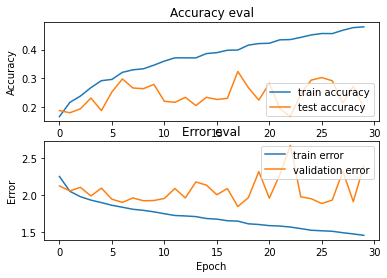

In [29]:
history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        batch_size=batch_size, epochs=30)

plot_history(history)

In [22]:
# Evaluate the model on the test data using `evaluate`
print("Evaluating model on test data...")
results = model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test loss:", results[0])
print("Test acc:", results[1])

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

Evaluating model on test data...
800/800 [==============================] - 0s 297us/step
Test loss: 2.0082841062545778
Test acc: 0.25999999046325684

Test accuracy: 0.25999999046325684
